# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
import tensorflow as tf
from scipy.io import loadmat

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
%cd "/content/gdrive/My Drive/Tensorflow Imperial/First_Course/Capstone_Project_1"

/content/gdrive/My Drive/Tensorflow Imperial/First_Course/Capstone_Project_1


In [5]:
# Run this cell to load the dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:
X_train, X_test = train['X'], test['X']
y_train, y_test = train['y'], test['y']

In [7]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1 , 0)

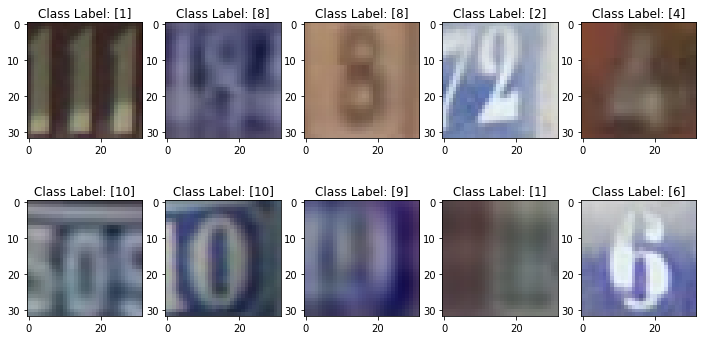

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    index = np.random.choice(X_train.shape[0])
    ax.imshow(X_train[index, :, :])
    ax.set_title("Class Label: "+str(y_train[index]))
plt.show()

In [9]:
X_train_grayscale = np.mean(X_train, 3).reshape(73257, 32, 32, 1)/255
X_test_grayscale = np.mean(X_test, 3).reshape(26032, 32, 32 ,1)/255

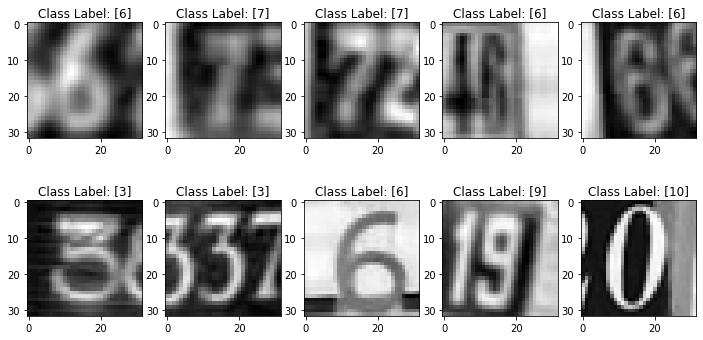

In [10]:
plot_data = np.mean(X_train,3)
fig, axes = plt.subplots(2, 5, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    index = np.random.choice(X_train_grayscale.shape[0])
    ax.imshow(plot_data[index, :, :], cmap='gray_r')
    ax.set_title("Class Label: "+str(y_train[index]))
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
y_train = y_train - 1
y_test = y_test - 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [12]:
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_mlp_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 305,962
Trainable params: 305,962
Non-trainable params: 0
__________________________________________________

In [13]:
checkpoint = ModelCheckpoint(filepath = 'best_check_point/checkpoint', save_best_only=True, save_weights_only=True, monitor='val_accuracy', verbose=2)
earlystop = EarlyStopping(patience=3, monitor='val_accuracy', verbose=1)

In [14]:
history = model.fit(X_train_grayscale, y_train, epochs=30, batch_size=256, validation_split=0.2, callbacks=[checkpoint, earlystop], verbose=2)

Epoch 1/30
229/229 - 4s - loss: 2.2095 - accuracy: 0.1992 - val_loss: 2.0496 - val_accuracy: 0.2759

Epoch 00001: val_accuracy improved from -inf to 0.27594, saving model to best_check_point/checkpoint
Epoch 2/30
229/229 - 1s - loss: 1.8379 - accuracy: 0.3578 - val_loss: 1.6657 - val_accuracy: 0.4194

Epoch 00002: val_accuracy improved from 0.27594 to 0.41940, saving model to best_check_point/checkpoint
Epoch 3/30
229/229 - 1s - loss: 1.4891 - accuracy: 0.4879 - val_loss: 1.3932 - val_accuracy: 0.5450

Epoch 00003: val_accuracy improved from 0.41940 to 0.54498, saving model to best_check_point/checkpoint
Epoch 4/30
229/229 - 1s - loss: 1.2813 - accuracy: 0.5813 - val_loss: 1.2609 - val_accuracy: 0.5864

Epoch 00004: val_accuracy improved from 0.54498 to 0.58640, saving model to best_check_point/checkpoint
Epoch 5/30
229/229 - 1s - loss: 1.1482 - accuracy: 0.6359 - val_loss: 1.1142 - val_accuracy: 0.6465

Epoch 00005: val_accuracy improved from 0.58640 to 0.64646, saving model to best_c

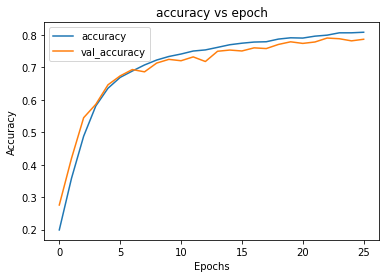

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("accuracy vs epoch")
plt.legend(['accuracy','val_accuracy'])
plt.show()

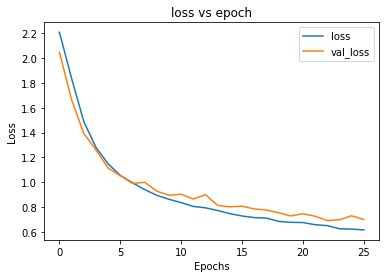

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("loss vs epoch")
plt.legend(['loss','val_loss'])
plt.show()

In [17]:
loss, acc = model.evaluate(X_test_grayscale, y_test, verbose=2)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))

814/814 - 1s - loss: 0.7796 - accuracy: 0.7709
loss: 0.7795859575271606
accuracy: 0.7708973288536072


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
checkpoint2 = ModelCheckpoint(filepath = 'best_check_point/checkpoint2', save_best_only=True, save_weights_only=True, monitor='val_accuracy', verbose=2)
earlystop = EarlyStopping(patience=3, monitor='val_accuracy', verbose=1)

In [19]:
def get_cnn_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,1)),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        MaxPool2D(pool_size =(2,2)),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        MaxPool2D(pool_size =(2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [20]:
history = model.fit(X_train_grayscale, y_train, epochs=30, batch_size=256, validation_split=0.2, callbacks=[checkpoint2, earlystop], verbose=2)

Epoch 1/30
229/229 - 30s - loss: 1.5050 - accuracy: 0.5010 - val_loss: 2.0466 - val_accuracy: 0.4056

Epoch 00001: val_accuracy improved from -inf to 0.40561, saving model to best_check_point/checkpoint2
Epoch 2/30
229/229 - 2s - loss: 0.8004 - accuracy: 0.7506 - val_loss: 1.1091 - val_accuracy: 0.7486

Epoch 00002: val_accuracy improved from 0.40561 to 0.74857, saving model to best_check_point/checkpoint2
Epoch 3/30
229/229 - 2s - loss: 0.6606 - accuracy: 0.7985 - val_loss: 0.6330 - val_accuracy: 0.8113

Epoch 00003: val_accuracy improved from 0.74857 to 0.81129, saving model to best_check_point/checkpoint2
Epoch 4/30
229/229 - 2s - loss: 0.5893 - accuracy: 0.8227 - val_loss: 0.5695 - val_accuracy: 0.8179

Epoch 00004: val_accuracy improved from 0.81129 to 0.81791, saving model to best_check_point/checkpoint2
Epoch 5/30
229/229 - 2s - loss: 0.5360 - accuracy: 0.8383 - val_loss: 0.4792 - val_accuracy: 0.8576

Epoch 00005: val_accuracy improved from 0.81791 to 0.85763, saving model to b

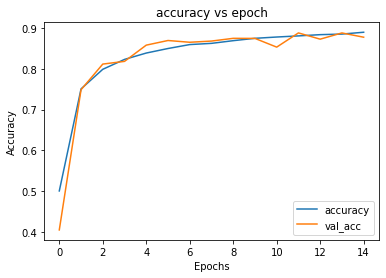

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("accuracy vs epoch")
plt.legend(['accuracy','val_acc'])
plt.show()

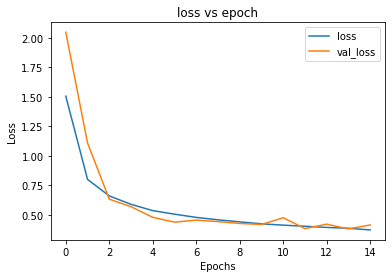

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("loss vs epoch")
plt.legend(['loss','val_loss'])
plt.show()

In [23]:
loss, acc = model.evaluate(X_test_grayscale, y_test, verbose=2)
print("loss: {}".format(loss))
print('accuracy: {}'.format(acc))

814/814 - 2s - loss: 0.4316 - accuracy: 0.8732
loss: 0.43158385157585144
accuracy: 0.8732329607009888


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [24]:
mlp_model = get_mlp_model()
mlp_model.load_weights('best_check_point/checkpoint')
cnn_model = get_cnn_model()
cnn_model.load_weights('best_check_point/checkpoint2')

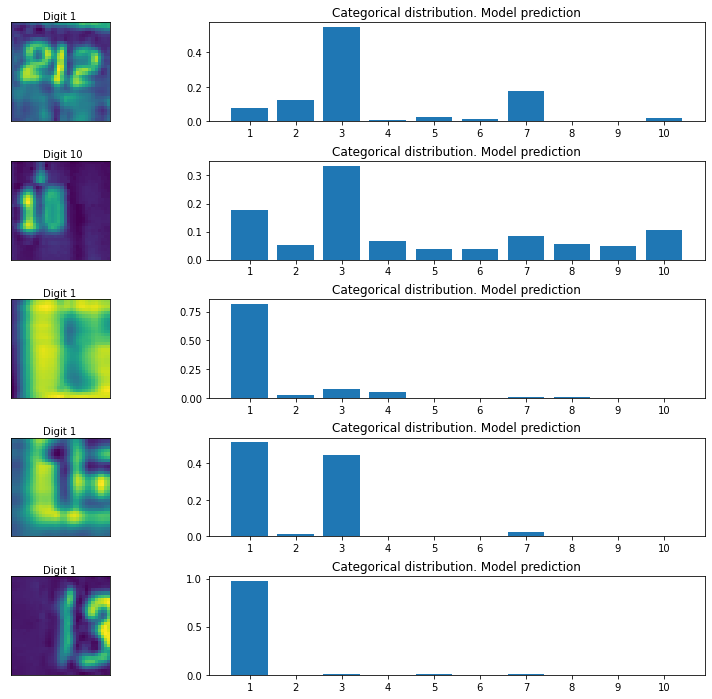

In [25]:
index = np.random.choice(X_test.shape[0], 5)
test_images = X_test_grayscale[index, ...]
test_labels = [np.argmax(encoder)+1 for encoder in y_test[index, ...]]

predictions = mlp_model.predict(test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, test_images, test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

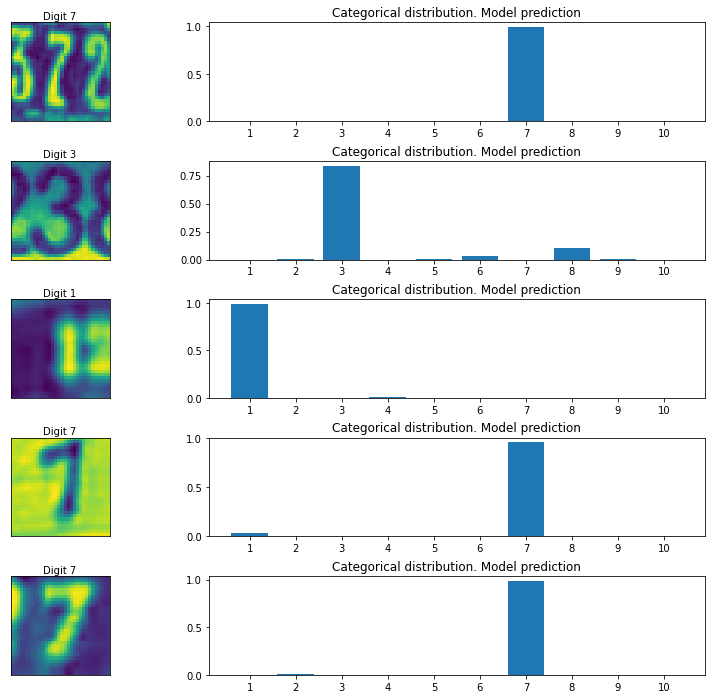

In [26]:
index = np.random.choice(X_test.shape[0], 5)
test_images = X_test_grayscale[index, ...]
test_labels = [np.argmax(encoder)+1 for encoder in y_test[index, ...]]

predictions = cnn_model.predict(test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, test_images, test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()